In [2]:
%matplotlib inline
import numpy as np
from astropy.io.votable import parse_single_table
import matplotlib.pyplot as plt
import glob, os
import pandas as pd
from astropy.cosmology import WMAP9 as cosmo
import numpy_indexed as npi
import pysynphot as S
from extinction import ccm89, apply
import sfdmap
from astropy.io import fits
from scipy import spatial
from scipy import stats
from astropy.cosmology import FlatLambdaCDM
import sfdmap
from PyAstronomy import pyasl
plt.style.use('my')
def smooth(y, box_pts):
    box = np.ones(box_pts)/box_pts
    y_smooth = np.convolve(y, box, mode='same')
    return y_smooth

/Applications/anaconda/lib/python2.7/site-packages/matplotlib/__init__.py:1069: UserWarning: Bad val "$TEMPLATE_BACKEND" on line #41
	"backend      : $TEMPLATE_BACKEND
"
	in file "/Applications/anaconda/lib/python2.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle"
	Key backend: Unrecognized backend string "$template_backend": valid strings are [u'pgf', u'cairo', u'MacOSX', u'CocoaAgg', u'gdk', u'ps', u'GTKAgg', u'nbAgg', u'GTK', u'Qt5Agg', u'template', u'emf', u'GTK3Cairo', u'GTK3Agg', u'WX', u'Qt4Agg', u'TkAgg', u'agg', u'svg', u'GTKCairo', u'WXAgg', u'WebAgg', u'pdf']
  (val, error_details, msg))


('/Users/legolason/study/sed/sed_data/candidate/repair_53234.txt', 0, 6)
/Users/legolason/study/sed/sed_data/candidate/spec-4195-55452-0817.fits
('/Users/legolason/study/sed/sed_data/candidate/repair_53636.txt', 1, 5)
/Users/legolason/study/sed/sed_data/candidate/spec-1836-54567-0270.fits
('/Users/legolason/study/sed/sed_data/candidate/repair_72908.txt', 2, 1)
/Users/legolason/study/sed/sed_data/candidate/spec-1734-53034-0275.fits
('/Users/legolason/study/sed/sed_data/candidate/repair_73244.txt', 3, 4)
/Users/legolason/study/sed/sed_data/candidate/spec-3856-55269-0766.fits
('/Users/legolason/study/sed/sed_data/candidate/repair_80648.txt', 4, 2)
/Users/legolason/study/sed/sed_data/candidate/spec-4487-55866-0160.fits
('/Users/legolason/study/sed/sed_data/candidate/repair_81617.txt', 5, 3)
/Users/legolason/study/sed/sed_data/candidate/spec-0930-52618-0627.fits
('/Users/legolason/study/sed/sed_data/candidate/repair_98898.txt', 6, 7)
/Users/legolason/study/sed/sed_data/candidate/spec-6136-5

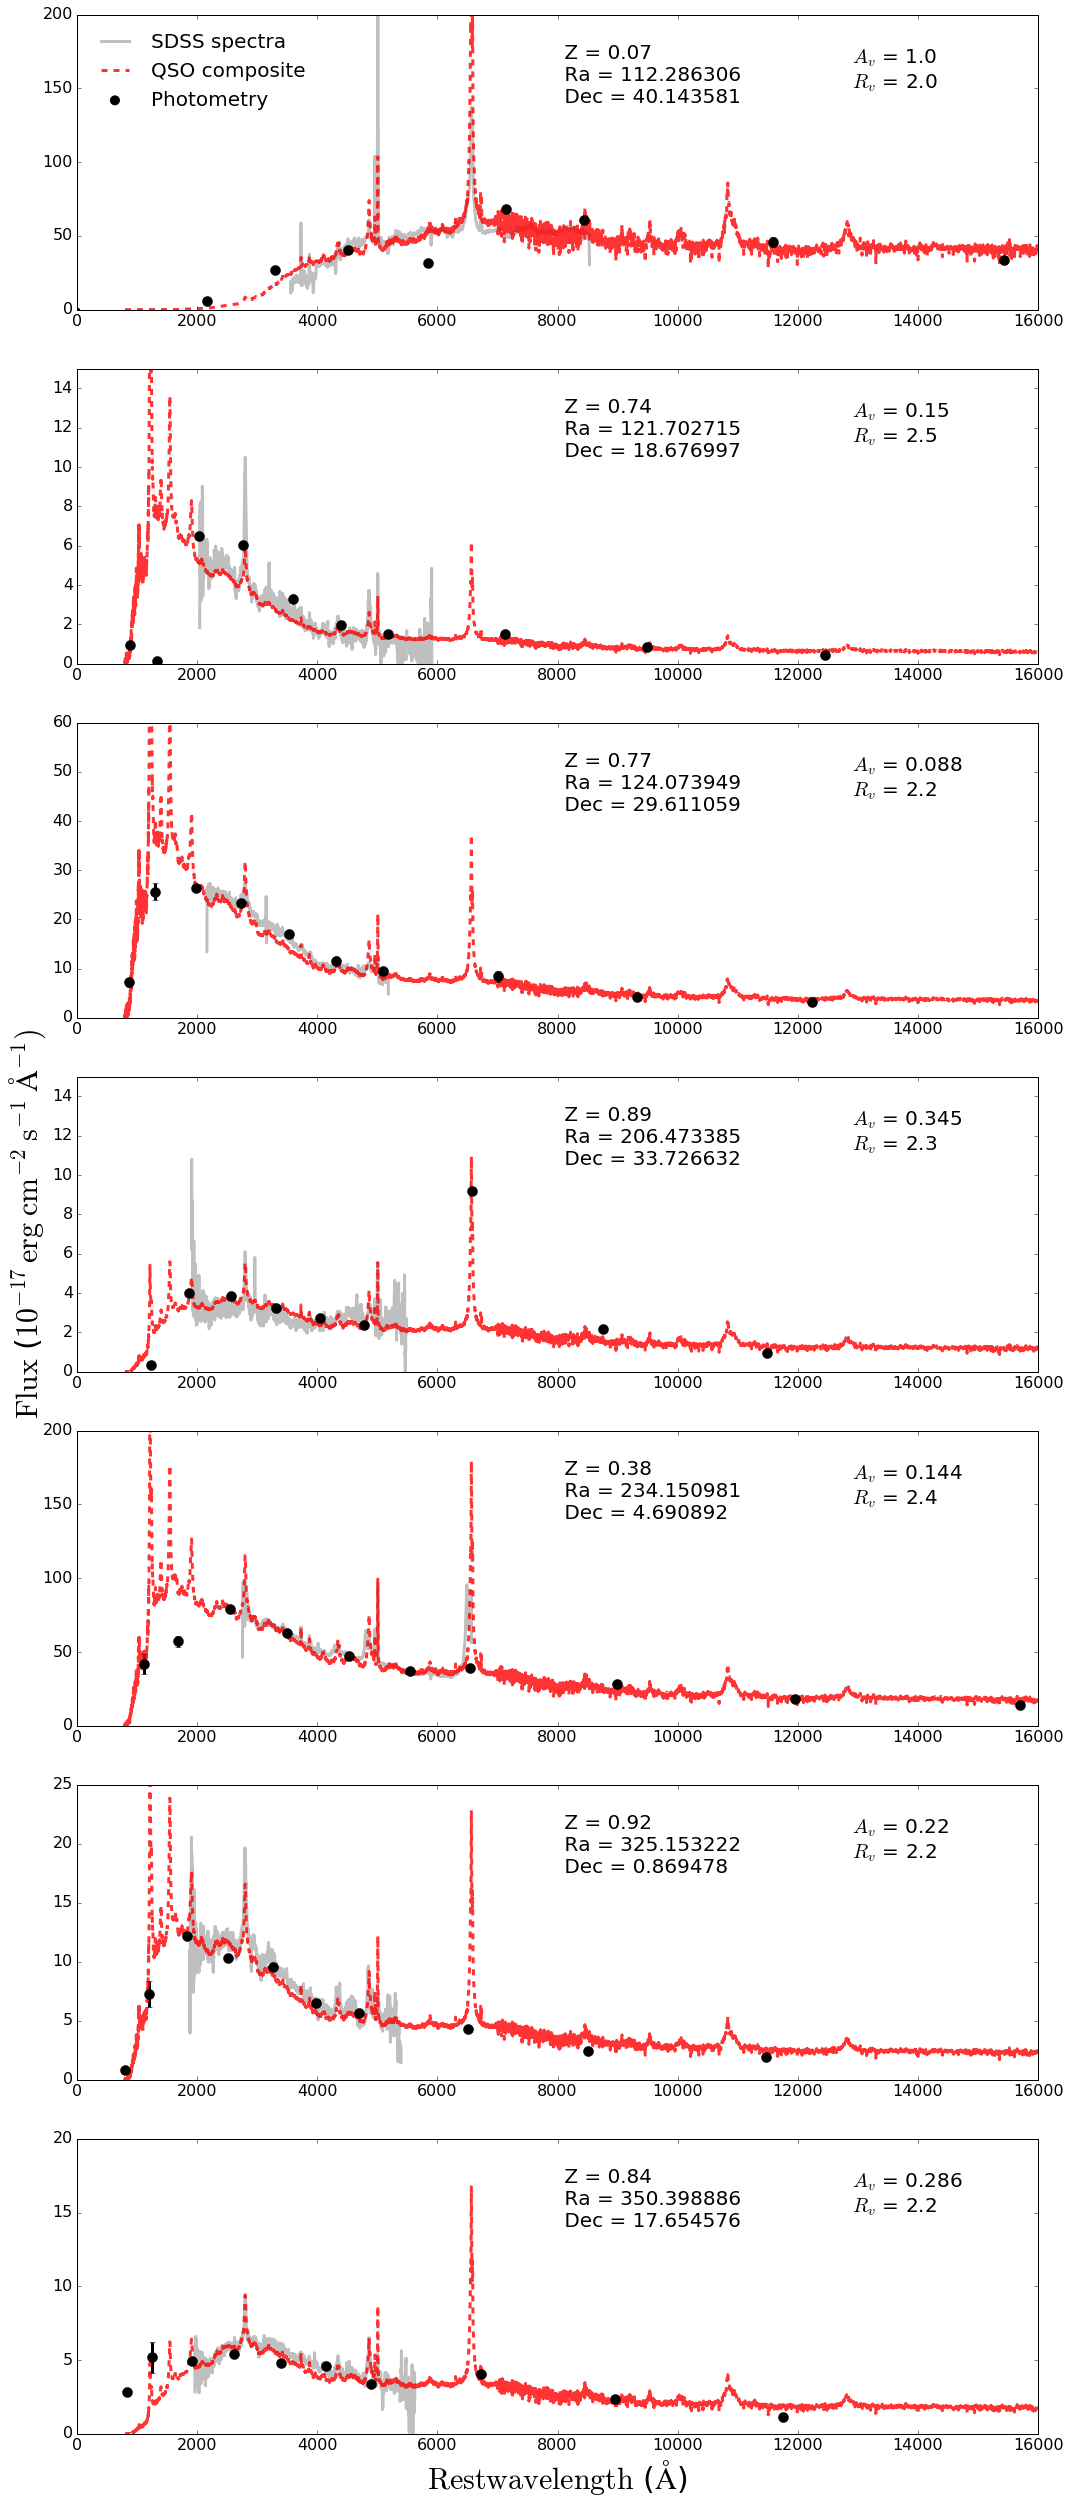

In [16]:
%matplotlib inline
import glob, os
from PyAstronomy import pyasl
import matplotlib.pylab as plt
plt.style.use('my')
def hz2A(wave):
    return 3.*10**8./(10.**wave)*10.**10

def smooth(y, box_pts):
    box = np.ones(box_pts)/box_pts
    y_smooth = np.convolve(y, box, mode='same')
    return y_smooth

path='/Users/legolason/study/sed/sed_data/candidate/'
pathz='/Users/legolason/study/sed/'
optical=np.genfromtxt(pathz+'vanden.txt')
IR=np.genfromtxt(pathz+'glikman.txt')
factor=IR[0,3]/optical[-1,1]
wv=np.concatenate([optical[:,0],IR[:,0]])
fx=np.concatenate([optical[:,1],IR[:,3]/factor])

#ebv, R_V,c1,c2,c4,c5,n,f
para=np.array([[0.1,2.2,-6.,2.3,0.46,5.9,6.67,1.6,25],\
               [0.06,2.4,-5.6,3.4,0.46,5.9,50.1,0.9,200],\
               [0.5,2.0,-6.6,3.8,0.46,5.9,134,1.3,200],\
               [0.15,2.3,-4.7,2.4,0.46,5.9,3.47,1.9,15],\
               [0.06,2.5,-4.6,1,0.46,5.9,1.74,1.2,15],\
               [0.04,2.2,-5.9,2.3,0.46,5.9,10,0.95,60],\
               [0.13,2.2,-10.6,4,0.46,5.9,5.1,0.95,20]]).reshape(7,9)


fig=plt.figure(figsize=(15,5.*7))
margin=0.08
plt.subplots_adjust(left=margin, bottom=margin-0.05, right=1.05-margin, top=1.07-margin,wspace=None, hspace=0.2)

for file in zip(glob.glob(path+"repair_*.txt"),range(len(glob.glob(path+"repair_*.txt"))),[6,5,1,4,2,3,7]):
    data=np.genfromtxt(file[0])
    print file
    name=file[0][-9:-4]
    z=data[0,-3]
    ra=data[0,0]
    dec=data[0,1]
    
    wave=hz2A(data[4:-2,2])
    flux=10**(data[4:-2,3]-data[4:-2,2])*3*10**(-5)/wave**2*10**17
    err=data[4:-2,-1]
    #plot spec---
    sub='sed_data/candidate/'
    
    ax1=plt.subplot(7,1,file[2])
    for ft in zip(glob.glob(pathz+sub+"*.fits")):
        
        sp0=fits.open(ft[0])
        spec0=sp0[0].header
        
        if (abs(spec0['plug_ra']-ra) <0.0008) and (abs(spec0['plug_dec']-dec) <0.0008):
           
            sp1=fits.open(ft[0])
            print ft[0]   
            redsh=sp1[2].data['z']
            spec1=sp1[1].data
            wave_sp=10**spec1['loglam']/(1.+redsh)
            flux_sp=spec1['flux']
            m = sfdmap.SFDMap('/Users/legolason/study/sed/dustmap') 
            flux_sp=pyasl.unred(wave_sp,flux_sp,m.ebv(ra,dec))
            plt.plot(wave_sp[10:-10],smooth(flux_sp[10:-10],10)*para[file[1],7],'grey',alpha=0.5,label='SDSS spectra') #f=1.8
            break   
    
    
    n=para[file[1],6]
    
    fluxUnred,Av,curve = pyasl.unred_guo(wv, fx*n, ebv=para[file[1],0], R_V=para[file[1],1],\
                                   c1=para[file[1],2],c2=para[file[1],3],c4=para[file[1],4],c5=para[file[1],5])
    plt.plot(wv, fluxUnred, 'r--',alpha=0.8,label='QSO composite')
    if (file[1]==1) or (file[1]==3) or file[1] ==5:
        flux[0:5]=flux[0:5]*0.7
    if file[1]==0:
        err[-1]=0.15
        err[-2]=1.1
    if file[1]==3:
        err[-1]=0.1
        err[-2]=0.15
    plt.errorbar(wave,flux,yerr=err,fmt='o',color='k')
    #print Av
    #plt.plot(wv,fx*flux[-3]/np.interp(wave[-3],wv,fx)*2,'b--')
    if file[1]==2:
        plt.scatter(-1,0.,c='k',label='Photometry')
        plt.legend(frameon=False,scatterpoints=1,fontsize=20,markerscale=2,loc=2)
    if file[1] == 6:
        plt.xlabel(r'$\rm Rest wavelength$ ($\rm \AA$)',fontsize=30)
    if file[1] ==3:
        plt.ylabel(r'$\rm Flux$ ($\rm 10^{-17}\, erg\;cm^{-2}\;s^{-1}\;\AA^{-1})$',fontsize=30)
    plt.xlim(0,16000)
    plt.ylim(0,para[file[1],-1])
    plt.text(0.5, 0.7, ' Z = '+str(np.round(z,2))+'\n Ra = '+str(ra)+'\n Dec = '+str(dec), transform=ax1.transAxes,fontsize=20)
    plt.text(0.8, 0.75, r' $A_{v}$ = '+str(Av) +'\n $R_{v}$ = '+str(para[file[1],1]), transform=ax1.transAxes,fontsize=20)
    wave=wave#*(1.+z)
    np.savetxt('/Users/legolason/study/sed/sed_data/candidate/data/redden_'+name+'.txt',\
    np.c_[np.repeat(ra,len(wave)),np.repeat(dec,len(wave)),np.repeat(z,len(wave)),wave,flux,err],header='ra='+str(ra)+' dec='+str(dec)+' z='+str(z)+\
               ' obs_wave(A) flux(erg/cm^2/s/A) flux_err ugriz JHK NUV FUV  ') 
plt.savefig('/Users/legolason/study/sed/sed_data/paper_fig/red.pdf')    
#plt.savefig('/Users/legolason/Desktop/red.pdf')    
    

In [19]:
import numpy as np
import scipy.interpolate as interpolate
from PyAstronomy import pyasl
from numpy.random import normal, randint
from kapteyn import kmpfit
import emcee
import corner

#redden ---------------------------------------------
def redden(p,x): # wave in A and flux in erg/cm^2/s/A
    global sed_w,sed_f
    #sed_f_smooth=smooth(sed_f,1000)[500:-500]
    f = interpolate.interp1d(sed_w,sed_f,bounds_error=False,fill_value=.1)
    new_sed_f=f(x)
    wave,flux = x,new_sed_f
    #plt.plot(x,new_sed_f,'m')
    c1,c2,c4,c5,R_V,ebv,factor = p
    x = 10000./ wave # Convert to inverse microns
    curve = x*0.

    # Set some standard values:
    x0 = 4.596
    gamma =  0.99
    c3 = 0.
    xcutuv = np.array([10000.0/2700.0])
    xspluv = 10000.0/np.array([2700.0,2600.0])

    iuv = np.where(x >= xcutuv)[0]
    N_UV = len(iuv)
    iopir = np.where(x < xcutuv)[0]
    Nopir = len(iopir)
    if (N_UV > 0): xuv = np.concatenate((xspluv,x[iuv]))
    else:  xuv = xspluv

    yuv = c1  + c2*xuv
    yuv = yuv + c3*xuv**2/((xuv**2-x0**2)**2 +(xuv*gamma)**2)
    yuv = yuv + c4*(0.5392*(np.maximum(xuv,c5)-c5)**2)
    yuv = yuv + R_V
    yspluv  = yuv[0:2]  # save spline points

    if (N_UV > 0): curve[iuv] = yuv[2::] # remove spline points

    # Compute optical portion of A(lambda)/E(B-V) curve
    # using cubic spline anchored in UV, optical, and IR
    xsplopir = np.concatenate(([0],10000.0/np.array([26500.0,12200.0,6000.0,5470.0,4670.0,4110.0])))
    ysplir   = np.array([0.0,0.26469,0.82925])*R_V/3.1
    ysplop   = np.array((np.polyval([-4.22809e-01, 1.00270, 2.13572e-04][::-1],R_V ),
            np.polyval([-5.13540e-02, 1.00216, -7.35778e-05][::-1],R_V ),
            np.polyval([ 7.00127e-01, 1.00184, -3.32598e-05][::-1],R_V ),
            np.polyval([ 1.19456, 1.01707, -5.46959e-03, 7.97809e-04, -4.45636e-05][::-1],R_V ) ))
    ysplopir = np.concatenate((ysplir,ysplop))

    if (Nopir > 0):
      tck = interpolate.splrep(np.concatenate((xsplopir,xspluv)),np.concatenate((ysplopir,yspluv)),s=0)
      curve[iopir] = interpolate.splev(x[iopir], tck)

    #Now apply extinction correction to input flux vector
    curve *= ebv

    return flux / 10.**(0.4*curve)

#mcmc function ------------------------------------------

def mcmc(p,wave,flux,err):

    def lnlike(p,wave,flux,err):
        # Residuals function for data with errors in y only
        c1,c2,c4,c5,R_V,ebv,factor = p
        res = -0.5*np.sum(((flux-factor*redden(p,wave))/err)**2+np.log(6.28*err**2) )
        return res

    def lnprob(p, wave,flux,err):
        lp = lnprior(p)
        if not np.isfinite(lp):
            return -np.inf
        return lp + lnlike(p, wave, flux, err)

    #def lnprior(p):
    #    c1,c2,c4,c5,R_V,ebv,factor = p
    #    if -6. < c1 < -4. and 2. < c2 < 4. and 0.45 < c4 < 0.46 and\
    #        5.8 < c5 < 5.9 and 1.2 < R_V <3. and 0.01 < ebv <1. and 0.9 < factor < 1.1:
    #        return 0.0
    #    return -np.inf
    ndim, nwalkers = 7, 100
    pos = [[p[0],p[1],p[2],p[3],p[4],p[5],p[6]] + 1e-4*np.random.rand(ndim) for i in range(nwalkers)]

    sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=(wave, flux, err))
    sampler.acceptance_fraction
    #print sampler.acceptance_fraction
    # Clear and run the production chain.
    sampler.run_mcmc(pos, 2000, rstate0=np.random.get_state())

    # Make the triangle plot.
    burnin = 500
    samples = sampler.chain[:, burnin:, :].reshape((-1, ndim))
    return samples



/Applications/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:35: RuntimeWarning: divide by zero encountered in divide


-5.99068213606 3.99382326493 1.41219529816 5.84860270762 2.00259171683 0.0291135992854 1.19992669743


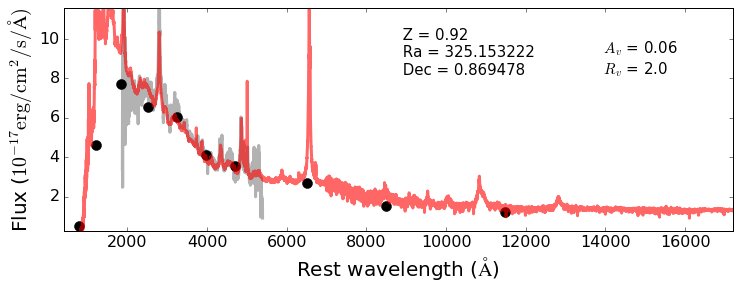

In [21]:
#Num 1
path='/Users/legolason/study/sed/sed_data/candidate/data/'
#for i in zip(['53234','53636','72908','73244','80648','81617','98898'],\
#            ['4195-55452-0817','1836-54567-0270','1734-53034-0275',\
#            '3856-55269-0766','4487-55866-0160','0930-52618-0627','6136-56206-0639'],np.arange(0,7)):


for i in zip(['53234'],['4195-55452-0817'],np.arange(0,1)): 

    fig=plt.figure(figsize=(12,4))
    ax=plt.subplot(111)
    # read photometric data --------
    phot=np.genfromtxt(path+'redden_'+i[0]+'.txt')
    ra=phot[0,0]
    dec=phot[0,1]
    z=phot[0,2]
    ph_w=phot[:,3]  # rest wavelength
    ph_f=phot[:,4]
    ph_f_err=phot[:,5]
    sort_ind=ph_w.argsort()  # order by FUV NUV ugriz, JHK
    ph_w=ph_w[sort_ind]
    ph_f=ph_f[sort_ind]
    ph_f_err=ph_f_err[sort_ind]
    #plt.plot(ph_w,ph_f,'bo')
    #print ph_w

    #read spectral data -------------
    sp1=fits.open(path+'spec-'+i[1]+'.fits')  
    redsh=sp1[2].data['z']
    spec1=sp1[1].data
    sp_w=10**spec1['loglam'][10:-10]/(1.+redsh)
    sp_f=spec1['flux'][10:-10]
    m = sfdmap.SFDMap('/Users/legolason/study/sed/dustmap') 
    sp_f=pyasl.unred(sp_w,sp_f,m.ebv(ra,dec))
    sp_f_err=np.sqrt(1./spec1['ivar'][10:-10])
    plt.plot(sp_w,smooth(sp_f,10),'grey',alpha=0.6)
    #plt.plot(sp_w[500:-500],smooth(sp_f,1000)[500:-500],'c')

    #normalize phot to spec i band 7625-------
    ind_i=np.where((sp_w*(1.+redsh) < 7650.) & (sp_w*(1.+redsh) > 7600.),True,False)
    factor_i=ph_f[5]/sp_f[ind_i].mean()
    ph_f=ph_f/factor_i
    plt.plot(ph_w,ph_f,'ko')

    #read qso SED --------------
    pathz='/Users/legolason/study/sed/'
    optical=np.genfromtxt(pathz+'vanden.txt')
    IR=np.genfromtxt(pathz+'glikman.txt')
    factor_SED=IR[0,3]/optical[-1,1]
    sed_w=np.concatenate([optical[:,0],IR[:,0]])
    sed_f=np.concatenate([optical[:,1],IR[:,3]/factor_SED])

    ind_k=np.where((sed_w*(1.+redsh) <21950.) & (sed_w*(1.+redsh) >21850.))
    factor_k=ph_f[9]/sed_f[ind_k].mean()
    sed_f=sed_f*factor_k
    #plt.plot(sed_w,sed_f,'r--',alpha=0.5)
    #plt.plot(sed_w,smooth(sed_f,1000),'b--')
    plt.xlim(ph_w.min()*0.5,ph_w.max()*1.5)
    plt.ylim(ph_f.min()*0.5,ph_f.max()*1.5)
  
    if i[2] == 2:
        wave_all=np.concatenate([ph_w[1:2],sp_w,ph_w[7:9]])
        flux_all=np.concatenate((ph_f[1:2],sp_f,ph_f[7:9]))
        flux_err_all=np.concatenate((ph_f_err[1:2],sp_f_err,ph_f_err[7:9]))
    if i[2] == 3:
        wave_all=np.concatenate([ph_w[1:2],sp_w,ph_w[7:10]])
        flux_all=np.concatenate((ph_f[1:2],sp_f,ph_f[7:10]))
        flux_err_all=np.concatenate((ph_f_err[1:2],sp_f_err,ph_f_err[7:10]))
    if i[2] ==4:
        wave_all=np.concatenate([ph_w[0:1],sp_w,ph_w[7:10]])
        flux_all=np.concatenate((ph_f[0:1],sp_f,ph_f[7:10]))
        flux_err_all=np.concatenate((ph_f_err[0:1],sp_f_err,ph_f_err[7:10]))
        
    if i[2] ==6:
        wave_all=np.concatenate([sp_w,ph_w[8:10]])
        flux_all=np.concatenate((sp_f,ph_f[8:10]))
        flux_err_all=np.concatenate((sp_f_err,ph_f_err[8:10]))
    if i[2]==0 or i[2] ==1 or i[2] ==5:    
        wave_all=np.concatenate([ph_w[0:2],sp_w,ph_w[7:10]])
        flux_all=np.concatenate((ph_f[0:2],sp_f,ph_f[7:10]))
        flux_err_all=np.concatenate((ph_f_err[0:2],sp_f_err,ph_f_err[7:10]))
    # no inf NAN  if = 0.0 err = 15%*flux 
    idx_noinf=np.where(np.isinf(abs(flux_err_all)),True,False)
    idx_zero=np.where(flux_err_all == 0, True,False)
    flux_err_all[idx_zero]= flux_all[idx_zero]*0.15
    flux_err_all[idx_noinf]= flux_all[idx_noinf]*0.15
    
    
    def lnprior(p):
        c1,c2,c4,c5,R_V,ebv,factor = p
        if  -6. < c1 < -4. and 2. < c2 < 4. and 0.15 < c4 < 1.47 and\
            5.8 < c5 < 6. and 2. < R_V <6. and 0.01 < ebv < 1. and 0.8 < factor < 1.2:
            return 0.0
        return -np.inf


    #------MCMC-----------------------------
    p0 = [-4.959,2.264,0.46,5.9,2.74,0.1,1]
    #if i[2] == 2:
    samples = mcmc(p0,wave_all,flux_all,flux_err_all)  
    c1,c2,c4,c5,R_V,ebv,factor= map(lambda v: (v[1], v[2]-v[1], v[1]-v[0]),zip(*np.percentile(samples, [16, 50, 84],axis=0)))
    #---------------------------------------
    
    Av=R_V[0]*ebv[0]
    print c1[0],c2[0],c4[0],c5[0],R_V[0],ebv[0],factor[0]

    fluxredden,Av,curve = pyasl.unred_guo(sed_w, sed_f, ebv=ebv[0], R_V=R_V[0],c1=c1[0],c2=c2[0],c4=c4[0],c5=c5[0])
    plt.plot(sed_w,fluxredden*factor[0],'r',alpha=0.6)
    plt.text(0.5, 0.7, ' Z = '+str(z)+'\n Ra = '+str(ra)+'\n Dec = '+str(dec), transform=ax.transAxes,fontsize=15)

    plt.text(0.8, 0.7, r' $A_{v}$ = '+str(np.round(Av,2))\
             +'\n $R_{v}$ = '+str(np.round(R_V[0],2)), transform=ax.transAxes,fontsize=15)
    plt.xlabel(r'Rest wavelength ($\rm \AA$)')
    plt.ylabel(r'Flux ($\rm 10^{-17} erg/cm^2/s/\AA)$')

/Applications/anaconda/lib/python2.7/site-packages/numpy/ma/core.py:6385: MaskedArrayFutureWarning: In the future the default for ma.maximum.reduce will be axis=0, not the current None, to match np.maximum.reduce. Explicitly pass 0 or None to silence this warning.
  return self.reduce(a)
/Applications/anaconda/lib/python2.7/site-packages/numpy/ma/core.py:6385: MaskedArrayFutureWarning: In the future the default for ma.minimum.reduce will be axis=0, not the current None, to match np.minimum.reduce. Explicitly pass 0 or None to silence this warning.
  return self.reduce(a)


(150000, 7)
2.00396545903 0.00443753183605


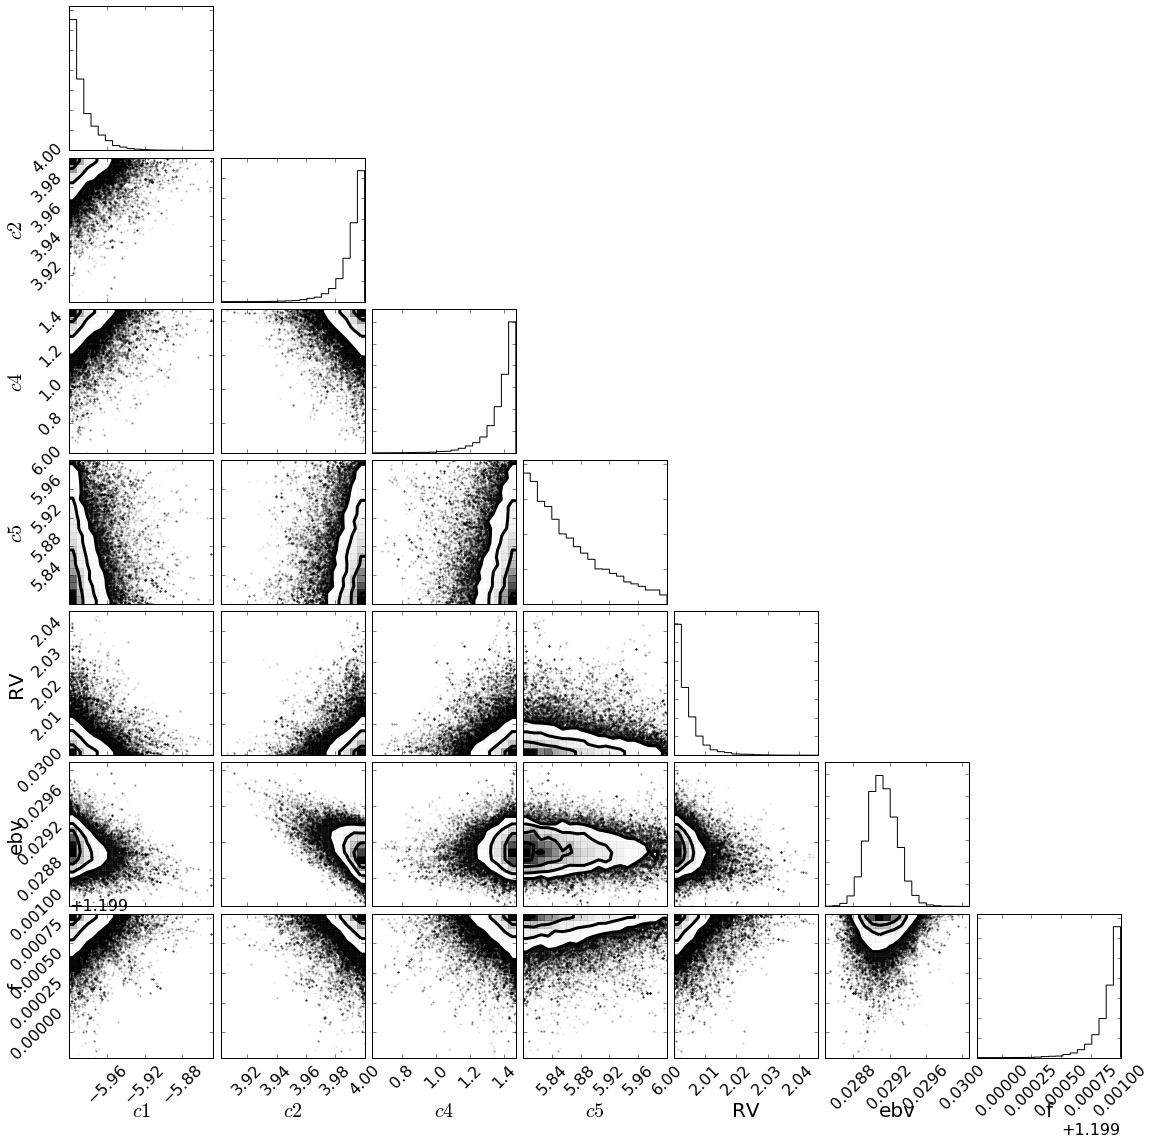

In [22]:
fig = corner.corner(samples, labels=["$c1$", "$c2$", "$c4$","$c5$","RV","ebv","f"])
ax.set_rasterized(True)
print samples.shape
x=np.arange(0,samples.shape[0],10)
Rv=samples[::10,-3]
#plt.plot(x,samples[::10,-3],'k')
print Rv.mean(),Rv.std()
